In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

<img src=../images/database-design-cricket-neelesh-vasnani.jpg>



# Sample Database Design for Cricket Data using SQLite
By: Neelesh Vasnani | 14 February 2021

Assignment #3 - 158.739 Introduction to Analytics - Master of Analytics - Massey University

In this notebook, all the previously acquired Cricket data is populated into a SQLite relational database in normalized schema form. Sample queries, views, and selected visualizations are then generated using this resulting database as the persistent data source.

### - Loading Libraries and Defining Functions

In [87]:
#importing required modules

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
from matplotlib import cm
import sqlite3
import datetime as dt

#setting up plotting options

%matplotlib inline
%reload_ext autoreload
%autoreload 2

rcParams['figure.figsize'] = 14,8
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'
plt.style.use('seaborn-white')
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
palette = sns.color_palette("Greens")

#display options for Pandas

pd.set_option('max_columns', 20)
pd.set_option('max_rows', 20)

In [205]:
#custom function to add bar labels to bar chart        
        
def addbarhlabels(ax, spacing=5):
    
    for rect in ax.patches:
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        space = 5
        ha = 'left'
        if x_value < 0:
            space *= -1
            ha = 'right'
        label = "{:.0f}".format(x_value)
        plt.annotate(
            label,                      
            (x_value, y_value),        
            xytext=(space, 0),          
            textcoords="offset points", 
            va='center',            
            ha=ha)  
        
#no borders in plot

def noborders(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    

In [ ]:
#loading sql
%load_ext sql

### - Database Schema

<img src=../images/cricket_rdb_schema.png>

The figure above shows the database schema relational model encompassing all the data. The database consists of five tables and several attributes. The two main tables are the players and matches tables which contain key data attributes about all the Cricket players and Cricket matches. 

The players table contains mostly numerical information about each Cricket player, such as number of matches played, runs scored, wickets taken, etc. However, it does not include which country a player belongs to. The playercountrymap table is a two-column table that maps players to their respective country short codes (e.g. ENG for England). In this way, there is a one-to-one relationship between the two through the primary key "player_id". The playercountrymap is linked to a table called "countrynamemap" which maps out country codes to their full country name. This "countrynamemap" is in turn linked to the countries table which contains country-level demographic variables such as population and gdp per capita. Through this chain of tables, players can easily be linked to the full names of their respective countries. Finally, the matches table contains information about the match results of each and every cricket match played. This table is also linked to the countries table through the foreign key "country". 

What follows is a step-by-step process of populating the database with the above-designed database schema in mind.

### - Importing Data from CSV

In [142]:
#Cricket players dataset

players=pd.read_csv('../datasets/players.csv', index_col="player_id")
players.head(2)

,Player,Mat,Runs,HS,Bat Av,100,Wkts,Bowl Av,5,Ct,St,Ave Diff,career_start,career_end,career_length
player_id,,,,,,,,,,,,,,,
1,T Armitage (ENG),2,33,21.0,11.00,0,0,0.0,0,0,0,0.0,1877,1877,1
2,C Bannerman (AUS),3,239,165.0,59.75,1,0,0.0,0,0,0,0.0,1877,1879,3


In [144]:
players.columns = ['player','matches','runs','highest_score','batting_average','hundreds','wickets','bowling_average',
'five_wickets','catches','stumpings','ave_diff','career_start','career_end','career_length']
players.head(2)

,player,matches,runs,highest_score,batting_average,hundreds,wickets,bowling_average,five_wickets,catches,stumpings,ave_diff,career_start,career_end,career_length
player_id,,,,,,,,,,,,,,,
1,T Armitage (ENG),2,33,21.0,11.00,0,0,0.0,0,0,0,0.0,1877,1877,1
2,C Bannerman (AUS),3,239,165.0,59.75,1,0,0.0,0,0,0,0.0,1877,1879,3


In [145]:
#Cricket matches dataset

matches=pd.read_csv('../datasets/matches.csv', index_col="Unnamed: 0")
matches.head(2)

,Team,Result,Margin,Toss,Bat,Opposition,Ground,Start Date,Format
0,Australia,won,45 runs,won,1st,England,Melbourne,1877-03-15,Test
1,England,lost,45 runs,lost,2nd,Australia,Melbourne,1877-03-15,Test


In [146]:
matches.columns = ['country','result', 'margin','toss','bat','opposition','ground','start_date','format']
matches.index.name='match_id'
matches.head(2)

,country,result,margin,toss,bat,opposition,ground,start_date,format
match_id,,,,,,,,,
0,Australia,won,45 runs,won,1st,England,Melbourne,1877-03-15,Test
1,England,lost,45 runs,lost,2nd,Australia,Melbourne,1877-03-15,Test


In [147]:
#Countries dataset

countries=pd.read_csv('../datasets/countries.csv', index_col="country")
countries.head(1)

,year,population_total,gdp_per_capita
country,,,
Arab World,2018,419790591.0,6601.825189


In [148]:
countries.columns = ['year','population','gdpcapita']
countries.index.name='country'
countries.head(1)

,year,population,gdpcapita
country,,,
Arab World,2018,419790591.0,6601.825189


In [149]:
#Player countries dataset

playercountrymap=pd.read_csv('../datasets/player_country_map.csv', index_col="player_id")
playercountrymap.head(2)

,player,country_short
player_id,,
1,T Armitage (ENG),ENG
2,C Bannerman (AUS),AUS


In [150]:
#Country short codes dataset

countrynamemap=pd.read_csv('../datasets/countrynamemap.csv', index_col="country_short")
countrynamemap.head(2)

,country
country_short,
AUS,Australia
INDIA,India


### - Creating Database

In [192]:
#connecting to database

%sql sqlite:///../datasets/cricket_rDB.db3

In [193]:
#foreign key checking = on

%sql sqlite:///../datasets/cricket_rDB.db3 PRAGMA foreign_keys = ON;

Done.


[]

Dropping any existing tables and creating five new tables in the database.

In [158]:
%%sql sqlite:///../datasets/cricket_rDB.db3

DROP TABLE  IF EXISTS matches;
DROP TABLE  IF EXISTS players;
DROP TABLE  IF EXISTS countries;
DROP TABLE  IF EXISTS countrynamemap;
DROP TABLE  IF EXISTS playercountrymap;

Done.
Done.
Done.
Done.
Done.


[]

In [159]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
DROP TABLE  IF EXISTS countries;

CREATE TABLE countries(
    country VARCHAR(50) NOT NULL,
    year INTEGER NOT NULL,  
    population INTEGER NOT NULL, 
    gdpcapita DECIMAL(10,5),
    PRIMARY KEY (country)
);

CREATE INDEX ix_countries_country ON countries(country);
SELECT * FROM countries

Done.
Done.
Done.
Done.


country,year,population,gdpcapita


Matches table:

In [160]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
DROP TABLE  IF EXISTS matches;

CREATE TABLE matches(
    match_id VARCHAR(50) NOT NULL,
    country VARCHAR(50) NOT NULL,  
    result VARCHAR(10) NOT NULL, 
    margin VARCHAR(50),
    toss VARCHAR(10) NOT NULL,  
    bat VARCHAR(10) NOT NULL,
    opposition VARCHAR(50) NOT NULL,
    ground VARCHAR(50) NOT NULL,  
    start_date DATE NOT NULL,
    format VARCHAR(10) NOT NULL,
    PRIMARY KEY (match_id)
    FOREIGN KEY (country) REFERENCES countries(country)
);

CREATE INDEX ix_matches_match_id ON matches (match_id);
SELECT * FROM matches

Done.
Done.
Done.
Done.


match_id,country,result,margin,toss,bat,opposition,ground,start_date,format


Countrynamemap table:

In [161]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
DROP TABLE  IF EXISTS countrynamemap;

CREATE TABLE countrynamemap(
    country_short VARCHAR(10) NOT NULL,
    country VARCHAR(50) NOT NULL, 
    PRIMARY KEY (country_short)
    FOREIGN KEY (country) REFERENCES countries(country)
);

CREATE INDEX ix_countrynamemap_country ON countrynamemap(country);
SELECT * FROM countrynamemap

Done.
Done.
Done.
Done.


country_short,country


Playercountrymap table:

In [162]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
DROP TABLE  IF EXISTS playercountrymap;

CREATE TABLE playercountrymap(
    player_id INTEGER NOT NULL,
    player VARCHAR(50) NOT NULL,
    country_short VARCHAR(10) NOT NULL, 
    PRIMARY KEY (player_id)
    FOREIGN KEY (country_short) REFERENCES countrynamemap(country)
);

CREATE INDEX ix_playercountrymap_player_id ON playercountrymap(player_id);
SELECT * FROM playercountrymap

Done.
Done.
Done.
Done.


player_id,player,country_short


Players table:

In [163]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
DROP TABLE  IF EXISTS players;

CREATE TABLE players(
    player_id INTEGER NOT NULL,
    player VARCHAR(50) NOT NULL,
    matches INTEGER NOT NULL,  
    runs INTEGER NOT NULL, 
    highest_score INTEGER,
    batting_average DECIMAL(10,5) NOT NULL,  
    hundreds INTEGER NOT NULL,
    wickets INTEGER NOT NULL,
    bowling_average DECIMAL(10,5) NOT NULL,  
    five_wickets INTEGER NOT NULL,
    catches INTEGER NOT NULL,
    stumpings INTEGER NOT NULL,  
    ave_diff DECIMAL(10,5) NOT NULL,
    career_start INTEGER NOT NULL,
    career_end INTEGER NOT NULL,
    career_length INTEGER NOT NULL,
    PRIMARY KEY (player_id)
    FOREIGN KEY (player_id) REFERENCES playercountrymap(player_id)
);

CREATE INDEX ix_players_player_id ON players (player_id);
SELECT * FROM players

Done.
Done.
Done.
Done.


player_id,player,matches,runs,highest_score,batting_average,hundreds,wickets,bowling_average,five_wickets,catches,stumpings,ave_diff,career_start,career_end,career_length


Checking foreign keys are being picked up fine:

In [195]:
%sql sqlite:///../datasets/cricket_rDB.db3 PRAGMA foreign_keys

Done.


foreign_keys
1


Checking if the database contains the created tables:

In [196]:
%sql SELECT name FROM sqlite_master WHERE type='table'

 * sqlite:///../datasets/cricket_rDB.db3
Done.


name
countries
matches
countrynamemap
playercountrymap
players


### - Populating Database with Imported Data

Opening connection to the database using Python:

In [165]:
connection = sqlite3.connect('../datasets/cricket_rDB.db3')

Writing imported data to SQL tables:

In [166]:
players.to_sql('players', connection, if_exists='append',)
connection.commit()

In [167]:
matches.to_sql('matches', connection, if_exists='append',)
connection.commit()

In [168]:
countries.to_sql('countries', connection, if_exists='append',)
connection.commit()

In [169]:
playercountrymap.to_sql('playercountrymap', connection, if_exists='append',)
connection.commit()

In [170]:
countrynamemap.to_sql('countrynamemap', connection, if_exists='append',)
connection.commit()

Checking if the database tables are populated with data:

In [180]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
SELECT * FROM players LIMIT 2

Done.


player_id,player,matches,runs,highest_score,batting_average,hundreds,wickets,bowling_average,five_wickets,catches,stumpings,ave_diff,career_start,career_end,career_length
1,T Armitage (ENG),2,33,21,11,0,0,0,0,0,0,0,1877,1877,1
2,C Bannerman (AUS),3,239,165,59.75,1,0,0,0,0,0,0,1877,1879,3


In [181]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
SELECT * FROM matches LIMIT 2

Done.


match_id,country,result,margin,toss,bat,opposition,ground,start_date,format
0,Australia,won,45 runs,won,1st,England,Melbourne,1877-03-15,Test
1,England,lost,45 runs,lost,2nd,Australia,Melbourne,1877-03-15,Test


In [182]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
SELECT * FROM countries LIMIT 2

Done.


country,year,population,gdpcapita
Arab World,2018,419790591,6601.825189
Caribbean small states,2018,7358958,10187.212309999999


In [183]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
SELECT * FROM countrynamemap LIMIT 2

Done.


country_short,country
AUS,Australia
INDIA,India


In [191]:
%%sql sqlite:///../datasets/cricket_rDB.db3
    
SELECT * FROM playercountrymap LIMIT 2

Done.


player_id,player,country_short
1,T Armitage (ENG),ENG
2,C Bannerman (AUS),AUS


### - Sample Queries and Visualizations

Average number of runs, wickets, and catches across all Cricket players:

In [207]:
%%sql 

SELECT AVG(runs) as AvgRuns, 
       AVG(wickets) as AvgWickets, 
       AVG(catches) as AvgCatches
FROM players

 * sqlite:///../datasets/cricket_rDB.db3
Done.


AvgRuns,AvgWickets,AvgCatches
819.4611659887662,26.844663955064885,16.510362192523726


Top 10 players by number of runs scored:

In [104]:
%%sql

SELECT player, runs
FROM players 
ORDER BY runs DESC LIMIT 10

 * sqlite:///../datasets/cricket_rDB.db3
Done.


player,runs
SR Tendulkar (INDIA),34357
KC Sangakkara (Asia/ICC/SL),28016
RT Ponting (AUS/ICC),27483
DPMD Jayawardene (Asia/SL),25957
JH Kallis (Afr/ICC/SA),25534
R Dravid (Asia/ICC/INDIA),24208
V Kohli (INDIA),22369
BC Lara (ICC/WI),22358
ST Jayasuriya (Asia/SL),21032
S Chanderpaul (WI),20988


Plotting the above query:

In [111]:
%%sql plot1df <<

SELECT player, runs
FROM players 
ORDER BY runs DESC LIMIT 15

 * sqlite:///../datasets/cricket_rDB.db3
Done.
Returning data to local variable plot1df


Text(0.5, 1.0, 'Top Players by Number of Runs Scored')

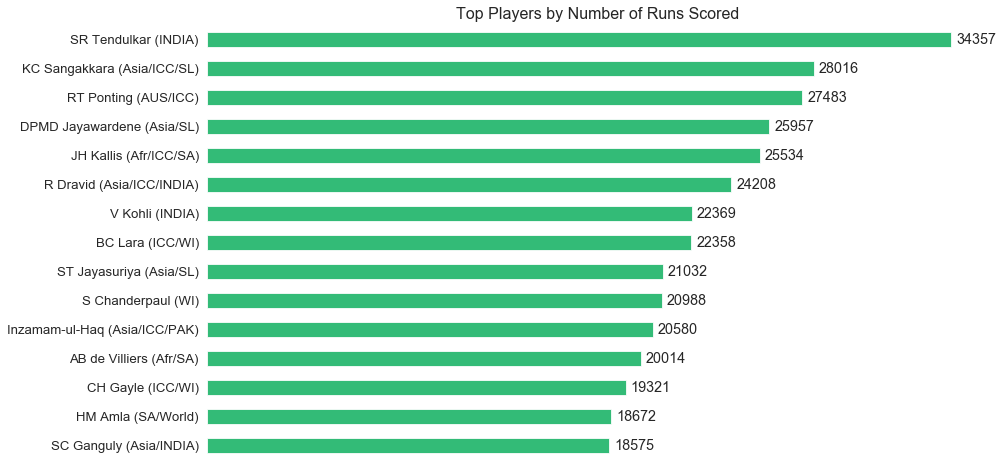

In [119]:
plot1 = plot1df.DataFrame()
plot1 = plot1.set_index('player')
ax = plot1.sort_values(by="runs", ascending=True).plot(kind="barh",color="#33bb77",legend=False)
addbarhlabels(ax)
noborders(ax)
plt.xticks([])
plt.ylabel("")
plt.title("Top Players by Number of Runs Scored", size=16)

Top 10 players by number of runs scored:

In [108]:
%%sql 

SELECT player, wickets
FROM players 
ORDER BY wickets DESC LIMIT 10

 * sqlite:///../datasets/cricket_rDB.db3
Done.


player,wickets
M Muralitharan (Asia/ICC/SL),1347
SK Warne (AUS/ICC),1001
A Kumble (Asia/INDIA),956
GD McGrath (AUS/ICC),949
Wasim Akram (PAK),916
JM Anderson (ENG),898
SM Pollock (Afr/ICC/SA),829
Waqar Younis (PAK),789
WPUJC Vaas (Asia/SL),761
SCJ Broad (ENG),760


Plotting the above query:

In [117]:
%%sql plot2df <<

SELECT player, wickets
FROM players 
ORDER BY wickets DESC LIMIT 15

 * sqlite:///../datasets/cricket_rDB.db3
Done.
Returning data to local variable plot2df


Text(0.5, 1.0, 'Top Players by Number of Wickets Taken')

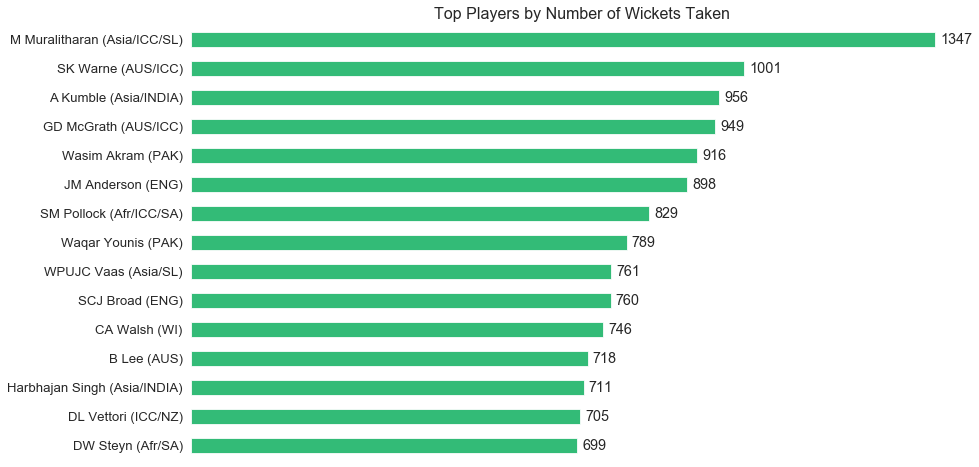

In [121]:
plot2 = plot2df.DataFrame()
plot2 = plot2.set_index('player')
ax = plot2.sort_values(by="wickets", ascending=True).plot(kind="barh",color="#33bb77",legend=False)
addbarhlabels(ax)
noborders(ax)
plt.xticks([])
plt.ylabel("")
plt.title("Top Players by Number of Wickets Taken", size=16)

Cricket Grounds with the most number of matches played:

In [24]:
%%sql 
    
SELECT 
    ground, 
    COUNT(match_id) as TotalMatchesPlayed
FROM matches 
GROUP BY ground
ORDER BY TotalMatchesPlayed DESC LIMIT 10

Done.


ground,TotalMatchesPlayed
Sharjah,518
Melbourne,506
Sydney,504
Dhaka,476
Harare,408
Colombo (RPS),322
Lord's,320
The Oval,298
Adelaide,296
Brisbane,258


Plotting the above query:

In [124]:
%%sql plot3df <<
    
SELECT 
    ground, 
    COUNT(match_id) as TotalMatchesPlayed
FROM matches 
GROUP BY ground
ORDER BY TotalMatchesPlayed DESC LIMIT 15

 * sqlite:///../datasets/cricket_rDB.db3
Done.
Returning data to local variable plot3df


Text(0.5, 1.0, 'Top Cricket Grounds by Number of Matches Played')

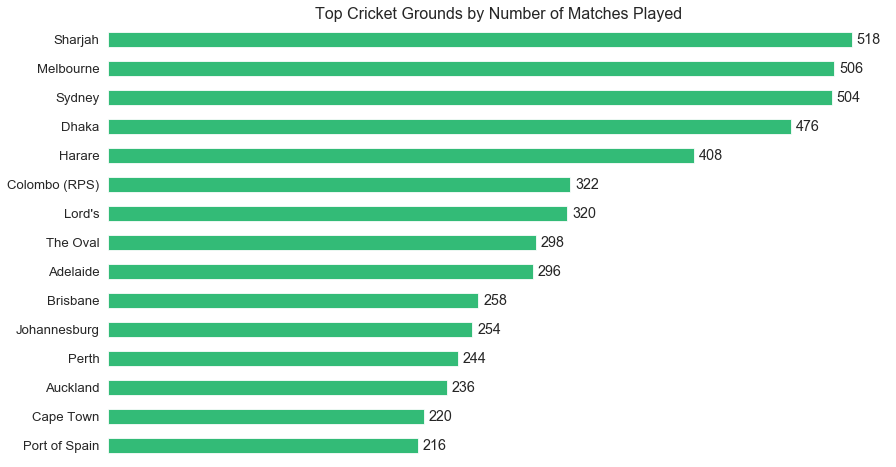

In [125]:
plot3 = plot3df.DataFrame()
plot3 = plot3.set_index('ground')
ax = plot3.sort_values(by="TotalMatchesPlayed", ascending=True).plot(kind="barh",color="#33bb77",legend=False)
addbarhlabels(ax)
noborders(ax)
plt.xticks([])
plt.ylabel("")
plt.title("Top Cricket Grounds by Number of Matches Played", size=16)

The query below uses two joins to retrieve the country information for each player and then stores it into a view.

In [76]:
%%sql 

CREATE VIEW players_merged AS
    SELECT *
    FROM players
    INNER JOIN(
        SELECT player_id, country 
        FROM playercountrymap
        INNER JOIN countrynamemap
    USING(country_short))
USING(player_id)

Done.


[]

The query below makes use of the view above to aggregate the total number of runs scored by each team.

In [126]:
%%sql

SELECT country, SUM(runs) as TotalRuns
FROM players_merged
GROUP BY country
ORDER BY TotalRuns DESC

 * sqlite:///../datasets/cricket_rDB.db3
Done.


country,TotalRuns
Australia,652660
England,613365
South Africa,518670
India,486592
West Indies,402664
New Zealand,389975
Sri Lanka,345095
Pakistan,310234
Zimbabwe,143724
Bangladesh,94620


Storing the query into a dataframe in order to generate a plot:

In [128]:
%%sql plot4df <<

SELECT country, SUM(runs) as TotalRuns
FROM players_merged
GROUP BY country
ORDER BY TotalRuns DESC

 * sqlite:///../datasets/cricket_rDB.db3
Done.
Returning data to local variable plot4df


Text(0.5, 1.0, 'Number of Runs Scored by Country')

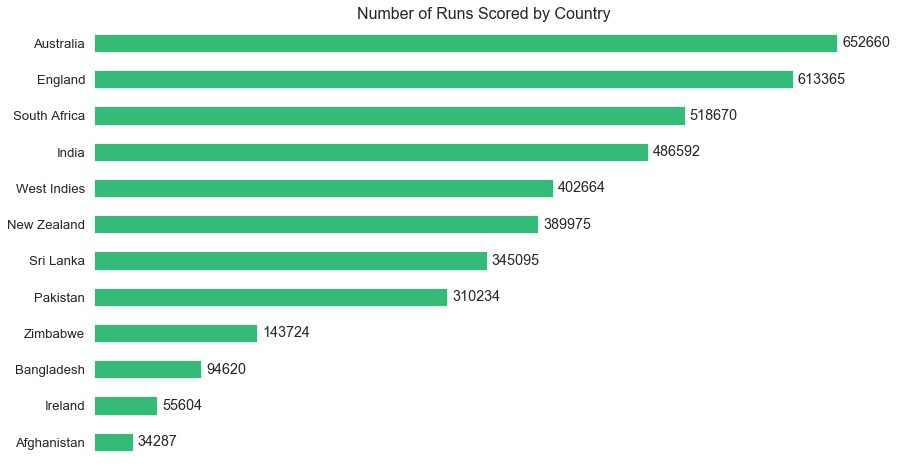

In [130]:
plot4 = plot4df.DataFrame()
plot4 = plot4.set_index('country')
ax = plot4.sort_values(by="TotalRuns", ascending=True).plot(kind="barh",color="#33bb77",legend=False)
addbarhlabels(ax)
noborders(ax)
plt.xticks([])
plt.ylabel("")
plt.title("Number of Runs Scored by Country", size=16)

Total number of matches played by the 12 main cricket nations:

In [203]:
%%sql 

SELECT country, COUNT(match_id) as TotalMatchesPlayed
FROM matches
WHERE country IN
        (SELECT country
         FROM countrynamemap) 
       and 
        opposition IN
        (SELECT country
         FROM countrynamemap) 
GROUP BY country
ORDER BY TotalMatchesPlayed DESC

 * sqlite:///../datasets/cricket_rDB.db3
Done.


country,TotalMatchesPlayed
Australia,1636
England,1498
India,1370
Pakistan,1296
West Indies,1259
Sri Lanka,1117
New Zealand,1115
South Africa,1025
Zimbabwe,615
Bangladesh,536


The follwing database view creates a subset of the matches data filtered by matches played only by the 12 main Cricket nations. This is achieved using a simple subquery:

In [67]:
%%sql 
    
CREATE VIEW matches_top12teams AS
    SELECT *
    FROM matches
    WHERE country IN
        (SELECT country
        FROM countrynamemap) 
        and 
        opposition IN
        (SELECT country
        FROM countrynamemap) 

Done.


[]

In [200]:
%%sql 
SELECT COUNT(*) FROM matches_top12teams

 * sqlite:///../datasets/cricket_rDB.db3
Done.


COUNT(*)
11744


In [201]:
%%sql 
SELECT COUNT(*) FROM matches

 * sqlite:///../datasets/cricket_rDB.db3
Done.


COUNT(*)
13588


As seen from the counts above, the subset from the database view contains 11,744 records while the original table contains 13,888 rows. This means that the view creation was successful.

Query to obtain the win and loss rate % by Country:

In [134]:
%%sql 
    
SELECT *, TotalWins*100/TotalMatchesPlayed as WinRatePct, 100 - TotalWins*100/TotalMatchesPlayed as LossRatePct
FROM (
    SELECT country, COUNT(match_id) as TotalMatchesPlayed
    FROM matches_top12teams 
    GROUP BY country
    ORDER BY TotalMatchesPlayed DESC) 
INNER JOIN
    (SELECT country, COUNT(match_id) as TotalWins
    FROM matches_top12teams
    WHERE result="won" 
    GROUP BY country
    ORDER BY TotalWins DESC)
USING(country)

 * sqlite:///../datasets/cricket_rDB.db3
Done.


country,TotalMatchesPlayed,TotalWins,WinRatePct,LossRatePct
Australia,1636,1021,62,38
England,1498,805,53,47
India,1370,734,53,47
Pakistan,1296,694,53,47
West Indies,1259,613,48,52
Sri Lanka,1117,519,46,54
New Zealand,1115,506,45,55
South Africa,1025,603,58,42
Zimbabwe,615,122,19,81
Bangladesh,536,153,28,72


Storing the query into a dataframe and then generating a plot:

In [135]:
%%sql plot5df <<
    
SELECT *, TotalWins*100/TotalMatchesPlayed as WinRatePct, 100 - TotalWins*100/TotalMatchesPlayed as LossRatePct
FROM (
    SELECT country, COUNT(match_id) as TotalMatchesPlayed
    FROM matches_top12teams 
    GROUP BY country
    ORDER BY TotalMatchesPlayed DESC) 
INNER JOIN
    (SELECT country, COUNT(match_id) as TotalWins
    FROM matches_top12teams
    WHERE result="won" 
    GROUP BY country
    ORDER BY TotalWins DESC)
USING(country)

 * sqlite:///../datasets/cricket_rDB.db3
Done.
Returning data to local variable plot5df


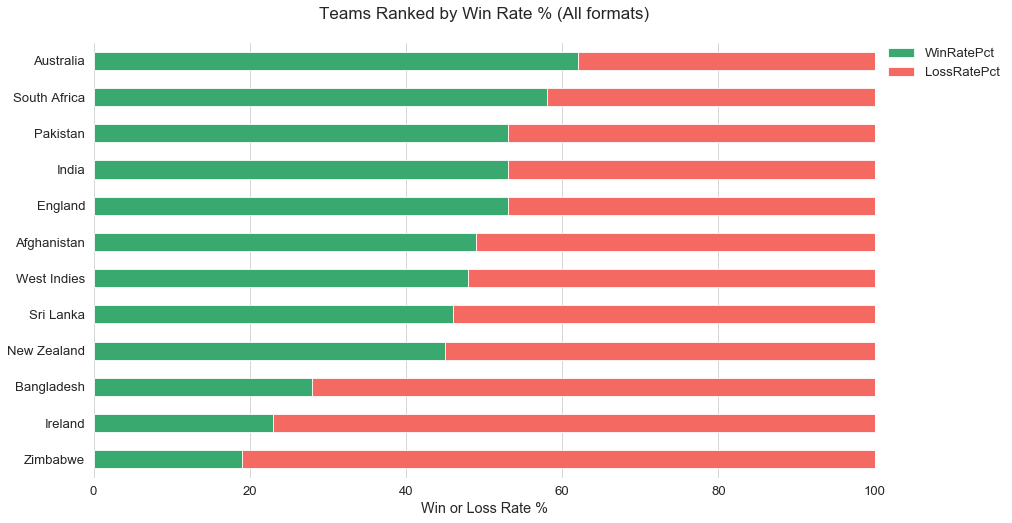

In [138]:
plot5 = plot5df.DataFrame()
plot5 = plot5.set_index('country')

cmap = sns.diverging_palette(143, 14, l=62, s=85, as_cmap=True)

ax = plot5[['WinRatePct','LossRatePct']].sort_values(by=['WinRatePct'], ascending=True).plot(
         kind="barh", 
         cmap=cmap,
         stacked=True, 
         legend=True)

plt.title('Teams Ranked by Win Rate % (All formats)\n', fontsize=17)
plt.ylabel('')
plt.xlabel('Win or Loss Rate %')
plt.xlim(0,100)
plt.legend(bbox_to_anchor=(1.01,1),borderaxespad=0)
noborders(ax)
plt.grid(True)

The goal of the following query is to generate a cross-tabulation of win rate percentages among teams, similar to what a pivot table normally generates.

In [183]:
%%sql 

CREATE VIEW crosswinrate AS

  SELECT country,
        sum(case when opposition = 'Afghanistan' then WinRatePct end) as Afghanistan,
        sum(case when opposition = 'Australia' then WinRatePct end) as Australia,
        sum(case when opposition = 'Bangladesh' then WinRatePct end) as Bangladesh,
        sum(case when opposition = 'England' then WinRatePct end) as England,
        sum(case when opposition = 'India' then WinRatePct end) as India,
        sum(case when opposition = 'Ireland' then WinRatePct end) as Ireland,
        sum(case when opposition = 'New Zealand' then WinRatePct end) as "New Zealand",
        sum(case when opposition = 'Pakistan' then WinRatePct end) as Pakistan,
        sum(case when opposition = 'South Africa' then WinRatePct end) as "South Africa",
        sum(case when opposition = 'Sri Lanka' then WinRatePct end) as "Sri Lanka",
        sum(case when opposition = 'West Indies' then WinRatePct end) as "West Indies",
        sum(case when opposition = 'Zimbabwe' then WinRatePct end) as Zimbabwe
FROM(
    SELECT 
        country, 
        opposition, 
        COUNT(case when result = 'won' then match_id end)*100 / COUNT(*) as WinRatePct
    FROM matches_top12teams
    GROUP BY country, opposition)
GROUP BY country

 * sqlite:///../datasets/cricket_rDB.db3
Done.


[]

In [185]:
%%sql
SELECT * FROM crosswinrate

 * sqlite:///../datasets/cricket_rDB.db3
Done.


country,Afghanistan,Australia,Bangladesh,England,India,Ireland,New Zealand,Pakistan,South Africa,Sri Lanka,West Indies,Zimbabwe
Afghanistan,None,0,53,0,0,65,0,0,0,20,37,67
Australia,100,None,93,57,57,100,73,65,57,66,58,91
Bangladesh,46,6,None,16,10,76,18,11,10,16,40,61
England,100,42,83,None,53,84,62,60,58,54,49,75
India,100,42,89,46,None,100,54,44,46,64,49,81
Ireland,34,0,23,15,0,None,0,12,0,0,18,53
New Zealand,100,26,81,37,45,100,None,43,30,56,53,83
Pakistan,100,34,88,39,55,87,56,None,36,60,50,91
South Africa,100,42,89,41,53,100,70,63,None,59,75,96
Sri Lanka,80,33,83,45,35,100,43,39,40,None,54,84


Plotting the cross tabulation into a heatmap:

In [186]:
%%sql plot6df <<
SELECT * FROM crosswinrate

 * sqlite:///../datasets/cricket_rDB.db3
Done.
Returning data to local variable plot6df


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 <a list of 12 Text xticklabel objects>)

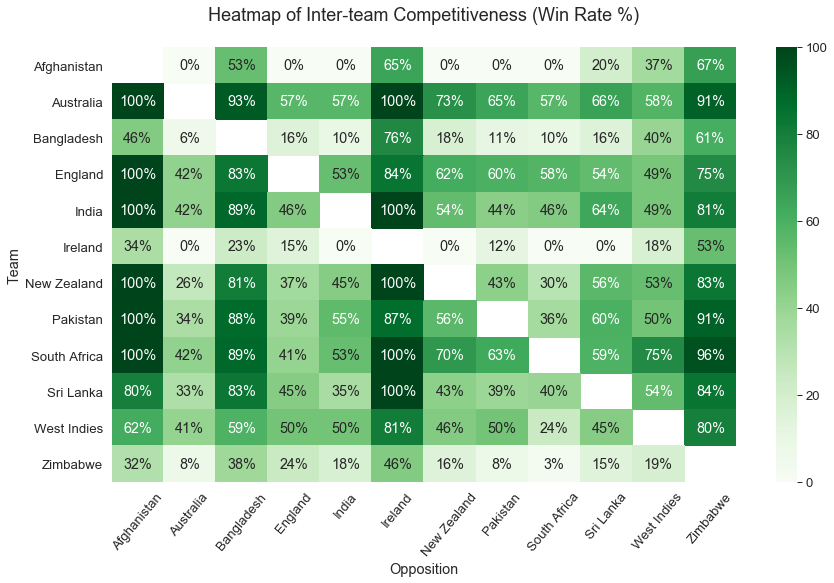

In [204]:
plot6 = plot6df.DataFrame()
plot6 = plot6.set_index('country')
res = sns.heatmap(plot6, cmap="Greens", annot=True, fmt='.0f')
for t in res.texts: t.set_text(t.get_text() + "%")
plt.xlabel("Opposition")
plt.ylabel("Team")
plt.title("Heatmap of Inter-team Competitiveness (Win Rate %)\n", size=18)
plt.xticks(rotation=50)

### - Conclusion

A key takeaway from the sample queries and visualizations generated is that the same, if not deeper, level of analysis can be performed using SQL queries as well. For some analyses, SQL queries are easier and faster than normal python group by operations or pivot tables. However, SQL queries can become lengthy and complicated for certain types of analyses. In these cases, the use of views can make the querying process much more efficient and methodical. SQL queries also offer more flexibility in that almost any imaginable output or inquiry can be generated by the use of joins, subqueries, and aggregate functions. This also means that there may be many ways of performing the same queries, so optimization is an integral part of writing SQL queries. 

<img src=../images/nv-analytics-footer.png>